# Libraries

In [2]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data preparation

We will be using Federal Reserve Economic Database (FRED) data concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

In [3]:
# Importing the data and using pandas datetime index feature
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)
df.sample(5)

,S4248SM144NCEN
DATE,
1998-01-01,3796
2003-06-01,7133
1996-08-01,5062
2009-04-01,9162
2015-01-01,8400


In [8]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
print(df.shape)
df = df.dropna()
df.shape

(325, 1)


(325, 1)

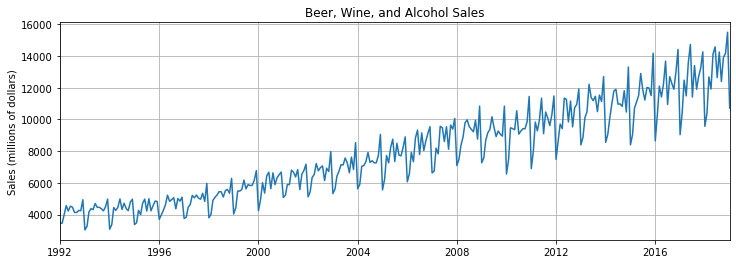

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df['S4248SM144NCEN'])
plt.grid()
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.autoscale(axis='x',tight=True) # Autoscale x grid around data

Data type has to be float.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [9]:
# Extract the values 
y = df['S4248SM144NCEN'].values.astype(float)

# Test size is one full cycle of the seasonality = 12 months
test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

The data in this dataset ranges from thousands in the beginning to tens of thousands towards the end. Normalisation of the dataset will assist with the training and generalisation of the model. In this case we will be using SciKit learn's `MinMaxScaler`.

## Data scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

When normalising the data, we will only use the min and max values of the training dataset to avoid data leakage. We need to fit the data, then transform it.

In [19]:
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))

## Prepare data for LSTM

Once the data has been normalised, it can be transformed to a tensor.

In [25]:
train_norm = torch.FloatTensor(train_norm).view(-1)

We create the windows for training.

In [26]:
def input_data(seq, ws, l=1):
    '''
    Creates the windows of data that willb e used for training.
    '''
    out = []
    for i in range(len(seq)-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+l]
        out.append((window,label))
    return out

In [35]:
window_size = 12
train_data = input_data(train_norm,window_size)
print(f'Expected values = {len(y)-len(test_set)-window_size}\tActual = {len(train_data)}')

Expected values = 301	Actual = 301


In [36]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))